<a href="https://colab.research.google.com/github/FanchonSora/AI-Project-Course/blob/main/Medical_prescription_to_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Cài đặt các thư viện cần thiết và Tesseract OCR
!sudo apt-get install tesseract-ocr -qq
!pip install opencv-python Pillow pytesseract pandas -qq
!pip install torch torchvision transformers easyocr sentence-transformers faiss-cpu -q
!sudo apt-get install tesseract-ocr -qq
!pip install easyocr pytesseract opencv-python pillow transformers sentence-transformers faiss-cpu

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr-osd.
Preparing to unpack .../tesseract-ocr-osd_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr.
Preparing to unpack .../t

In [3]:
!pip show easyocr opencv-python PIL


Name: easyocr
Version: 1.7.2
Summary: End-to-End Multi-Lingual Optical Character Recognition (OCR) Solution
Home-page: https://github.com/jaidedai/easyocr
Author: Rakpong Kittinaradorn
Author-email: r.kittinaradorn@gmail.com
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: ninja, numpy, opencv-python-headless, Pillow, pyclipper, python-bidi, PyYAML, scikit-image, scipy, Shapely, torch, torchvision
Required-by: 
---
Name: opencv-python
Version: 4.11.0.86
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy
Required-by: dopamine_rl, imgaug


In [5]:
# 2. Mount Google Drive chứa dữ liệu
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 3. Import các thư viện
import os
import cv2
import pytesseract
import easyocr
import pandas as pd
from PIL import Image, ImageDraw
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import torch

In [7]:
# 4. Khởi tạo các mô-đun AI
# --------------------------------------------------------
# a) Khởi tạo EasyOCR cho tiếng Anh.
#    Nếu bạn muốn nhận diện ngôn ngữ khác (VD: tiếng Việt),
#    có thể thêm mã ngôn ngữ tương ứng: ['en', 'vi']
reader = easyocr.Reader(['en'])

# b) Khởi tạo pipeline cho Named Entity Recognition (NER)
#    Sử dụng model "dslim/bert-base-NER" đã được fine-tune
ner_pipeline = pipeline(
    "ner",
    model="dslim/bert-base-NER",
    aggregation_strategy="simple"
)

# c) Khởi tạo mô hình SentenceTransformer
#    để tạo embedding vector cho tên thuốc
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# 4. Định nghĩa đường dẫn tới các thư mục và file dữ liệu
# Thư mục chứa ảnh đơn thuốc
# Thư mục lưu các file OCR text tương ứng với ảnh đơn thuốc
# File CSV chứa metadata của DrugBank (giả sử file có cột: drug_id, drug_name, description, [drug_image_path])
# Định nghĩa đường dẫn tới thư mục chứa ảnh của thuốc (drug_images)
# --------------------------------------------------------
prescription_images_folder = '/content/drive/MyDrive/AI_Project/dataset/prescription_images'
prescription_texts_folder = '/content/drive/MyDrive/AI_Project/dataset/prescription_texts'
drugbank_metadata_path = '/content/drive/MyDrive/AI_Project/dataset/drugbank_metadata.csv'
drug_images_folder = '/content/drive/MyDrive/AI_Project/dataset/drug_images'

In [9]:
def ocr_image(image_path):
    """
    Sử dụng EasyOCR để nhận diện chữ trong ảnh đơn thuốc.
    Đầu tiên mở ảnh bằng Pillow (PIL), chuyển thành numpy array rồi gọi EasyOCR.
    """
    from PIL import Image
    import numpy as np
    try:
        # Mở ảnh và chuyển đổi về RGB
        img_pil = Image.open(image_path).convert('RGB')
        # Chuyển sang numpy array
        img_np = np.array(img_pil)
    except Exception as e:
        print("Lỗi khi mở ảnh với PIL:", e)
        return ""

    # Gọi EasyOCR với numpy array
    result = reader.readtext(img_np, detail=0)
    return " ".join(result)

In [10]:
def extract_drug_names(text):
    """
    Sử dụng pipeline NER (Named Entity Recognition) để tìm
    các thực thể có nhãn MISC (thường là tên riêng,
    có thể bao gồm tên thuốc) trong văn bản OCR.
    """
    entities = ner_pipeline(text)
    # Lọc ra những entity có label = 'MISC'
    drug_names = [entity['word'] for entity in entities if entity['entity_group'] == 'MISC']
    return drug_names

In [11]:
def search_drug_info(drug_name, drugbank_df, index, drug_embeddings):
    """
    Tìm kiếm thuốc gần đúng nhất trong DrugBank sử dụng FAISS & Sentence Transformers.

    - drug_name: Tên thuốc tìm kiếm (chuỗi).
    - drugbank_df: DataFrame chứa metadata thuốc (mã, mô tả, v.v.).
    - index: FAISS Index đã được xây dựng.
    - drug_embeddings: Mảng embeddings của cột 'drug_name' trong drugbank_df.
    """
    # Tạo embedding cho từ khóa tìm kiếm
    query_embedding = sbert_model.encode(drug_name, convert_to_tensor=True).cpu().numpy()

    # Tìm trong FAISS Index (top 1 kết quả)
    D, I = index.search(query_embedding.reshape(1, -1), 1)

    best_match_idx = I[0][0] if I[0][0] != -1 else None
    if best_match_idx is not None:
        return drugbank_df.iloc[best_match_idx]
    else:
        return None

In [12]:
# Đọc file CSV chứa metadata thuốc
drugbank_df = pd.read_csv(drugbank_metadata_path, encoding='cp1252')

In [13]:
# 7. Xây dựng FAISS index cho cột 'drug_name'
# Tạo embeddings cho tất cả tên thuốc trong DataFrame
drug_embeddings = sbert_model.encode(drugbank_df['drug_name'].tolist(), convert_to_tensor=True).cpu().numpy()

# Khởi tạo FAISS Index (sử dụng L2 distance)
d = drug_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(drug_embeddings)

🚀 Đang xử lý ảnh đơn thuốc: 1.jpg
📄 Kết quả OCR:
Dr B; Who Farmstrcct 12 Kirkvillc tel, 3876 uate Lav 1994 ttriw 0.12 m% theoh ~ M0,7 44 hlt Lm Ms/Mr Pehuiof 30 address; 7v Yer+ Agc:
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 10.jpg
📄 Kết quả OCR:
Dr; MRCP (Uk) FrCA Ietuese Corsultant '{Oanto! CCT (Gasto) Livat Ttanuplart #euems"b Apollo [GAstRoenteroloGy No: 46200 Gastroenterologisl] and Wransplanl Hepaloloqist 040 2360 77 / Fot Extn 4005i14 Emaappoontments CJi Dem0005/0 A 6 AMt : 7102778809 aocpolav@gmail com yle/u To So Eve e IT MAY ConCeRn Thu U Jnlonm ~kat Mr- CK . SAmuel 6lyr | Malz Uu ccuuntly  admuttaf urdu Cau wiJh  Tp.No: 36+s88 y He 1 (usuly  Wrdiqeiy talii w CCU swesaSspsu tr dh Mobs Lui okstex? sNh Axpiraben   pruumonia )  Y6 fuku  needs  lerpilal alout & -l0 768 lorblut TF Jo 6 and Kurdly do -ba hnee dkul &n kprm Fuuki; Yau DE NAVEEN POLAVABAPU RCP Ln) WRCp Eio) VacP C_vo] CCS] (Gazuo) Loazs Cansuteni Trcplznl| Rad %o-2255 Hospi

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


📄 Kết quả OCR:
DR; R; CombB t399 Zo Eih"fifzo 'Hj3 (stta+ ~rxx dyooek qp] Cszuk_@utak Emul 1Z3 77 i icott Dou Or eaupl 5322 734 1s 3k  12
🔍 Tên thuốc nhận diện: ['Dou']
✅ **Thông tin thuốc được trích xuất:**
🔹 **Tên:** Dorzolamidum
💊 **Mô tả:** "B?nh glaucoma (t?ng nh?n  p) ?? gi?m  p l?c trong m?t"
🔗 **Mã DrugBank:** DB005
🖼️  Ảnh thuốc: /content/drive/MyDrive/AI_Project/dataset/drug_images/dorzolamidum.jpg


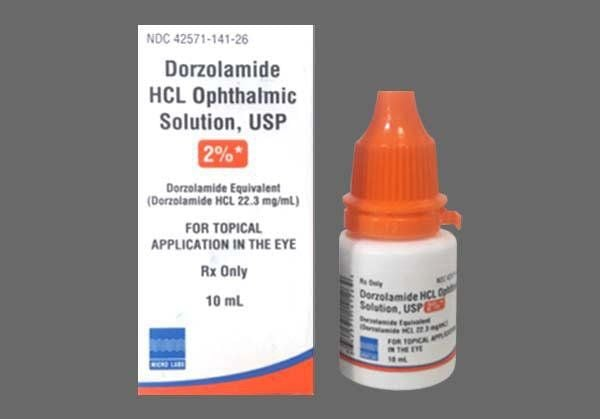

🚀 Đang xử lý ảnh đơn thuốc: 107.jpg
📄 Kết quả OCR:
R 78740 3 , > & es 6wdecec af Suc L 1 E: &5 4r40 ~l Jx Uea Jau ~ as 8 < - 3 1 n E HARRIMAN & FOSTER, dueb Registered Pharmacists, ~ceea dut Os WAITINSVILLE, MA8S. No. 424 {ocou M: D 03 Tr ! ~is Auxti. Ka;
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 116.jpg
📄 Kết quả OCR:
KAMBNENI R T A [ nGmad Ka Udcu 46|~ L odnu td u dhatrut ck ENt Will 2021/4013 IJe 6s Co Iu (ss ep baranoa  Giu "Lotrl t He u8h (U Gfosomal Glscuc R bieclon < Lox weele 4 nleo Yec k n Dr N.APOORVA REDDY Munir Re; Na 100275 Keid End Nect Oncoiutgeon (Rcs,Uki Contutznt ENT Hezd = Ne:' Sunjery raminen] Hosp (als LeNagaiHyc-68 Ozzderabad - 500068,TS (INDIA) 0-mail; Kamineni@kapiner?0r99879998324022272_ Ka kaminenihospilals com A 0 $ Ratent Lumo ^ menr{ Amk head kudk (abis _ B Nagar 24022277 24022222 5
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 119.jpg
📄 Kết quả OCR:
DR BAEA #apbFLegac @oz

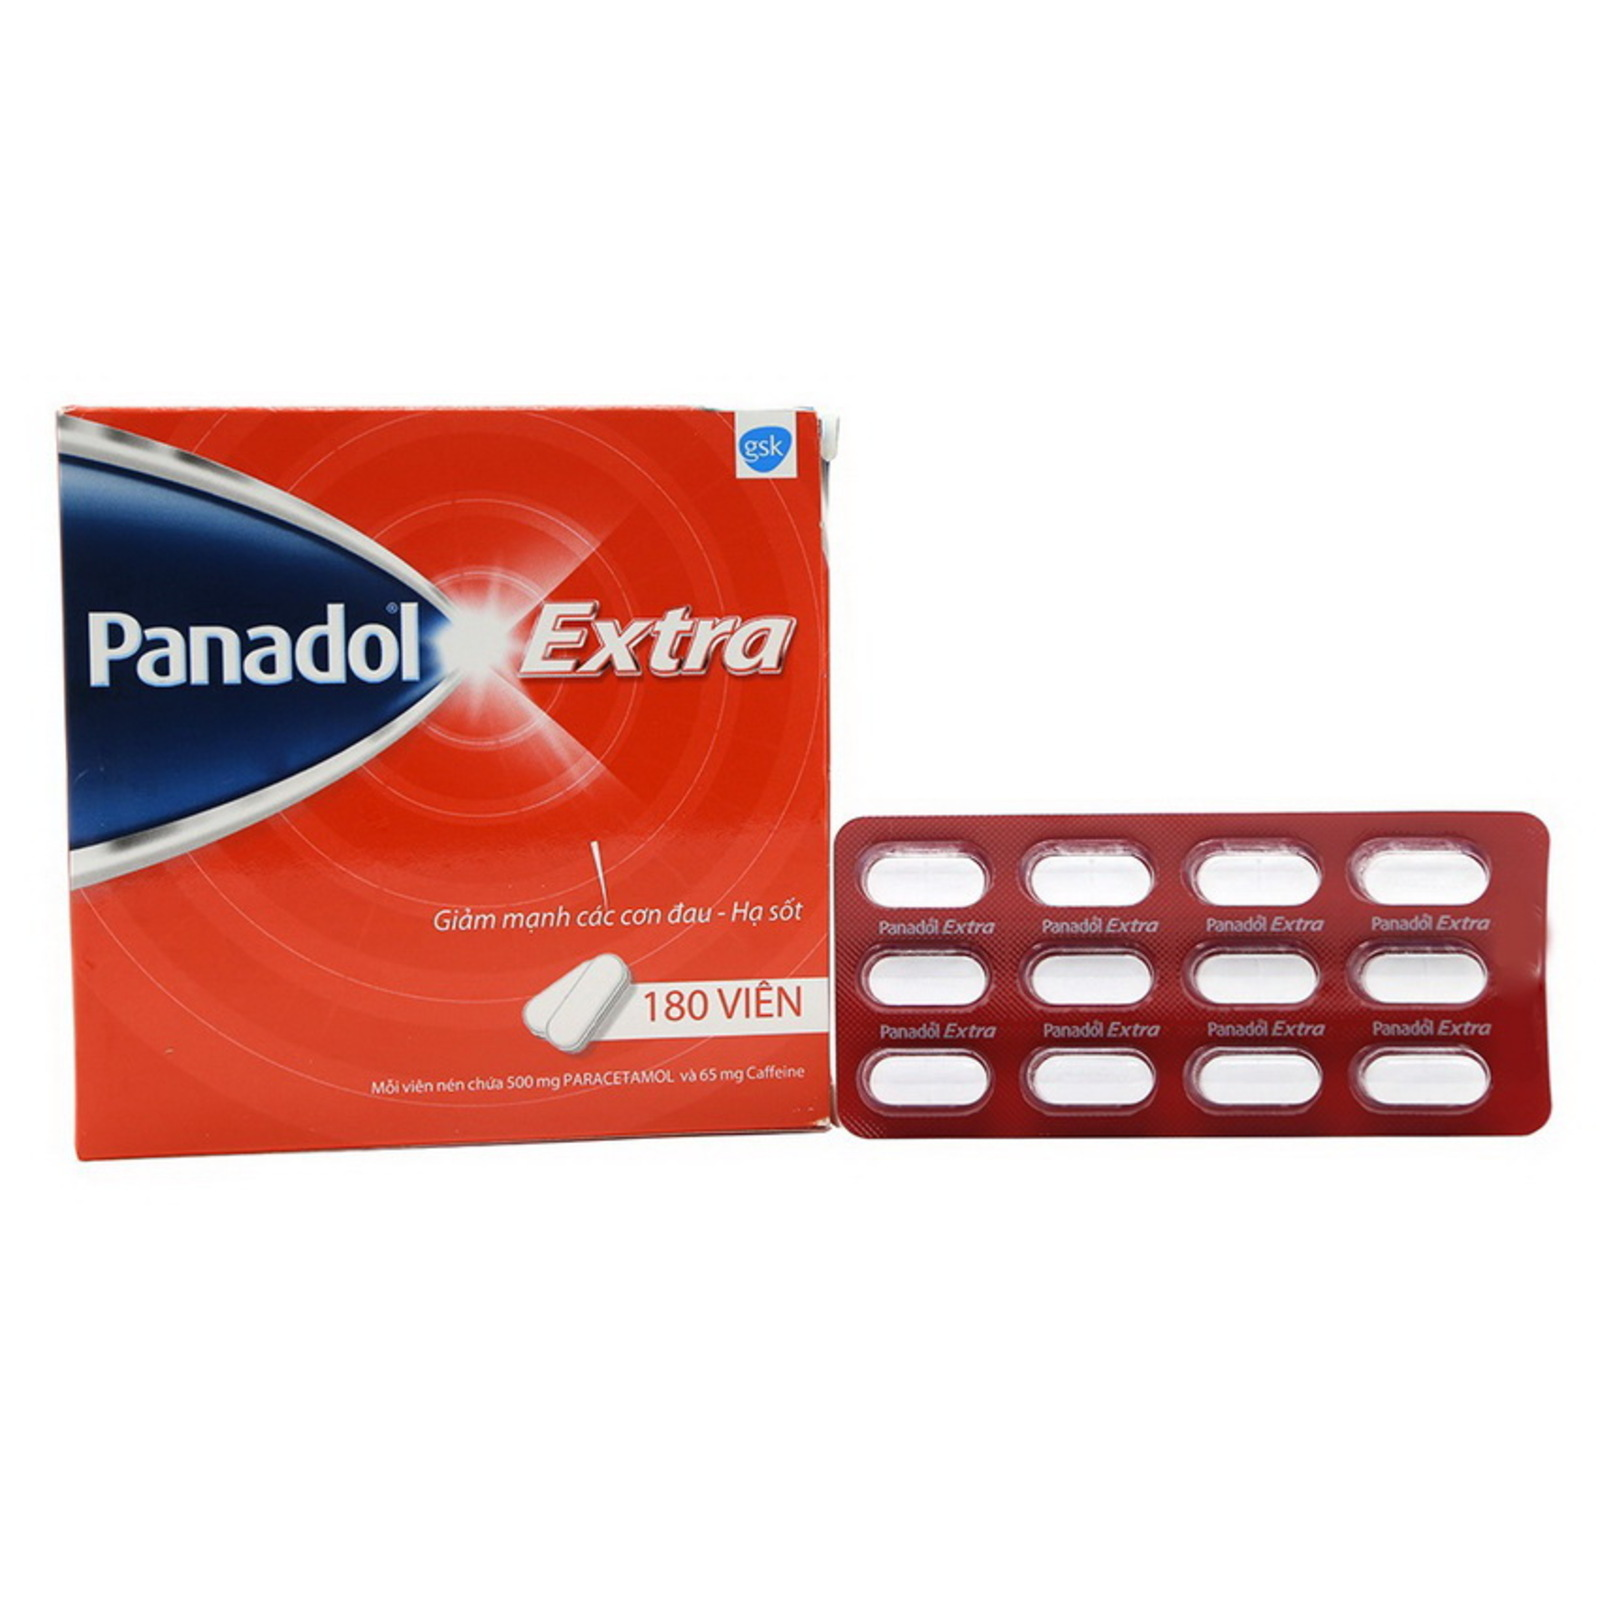

🔹 **Tên:** Ibuprofen
💊 **Mô tả:** "Thu?c gi?m ?au kh ng viˆm"
🔗 **Mã DrugBank:** DB003
🖼️  Ảnh thuốc: /content/drive/MyDrive/AI_Project/dataset/drug_images/ibuprofen.jpg


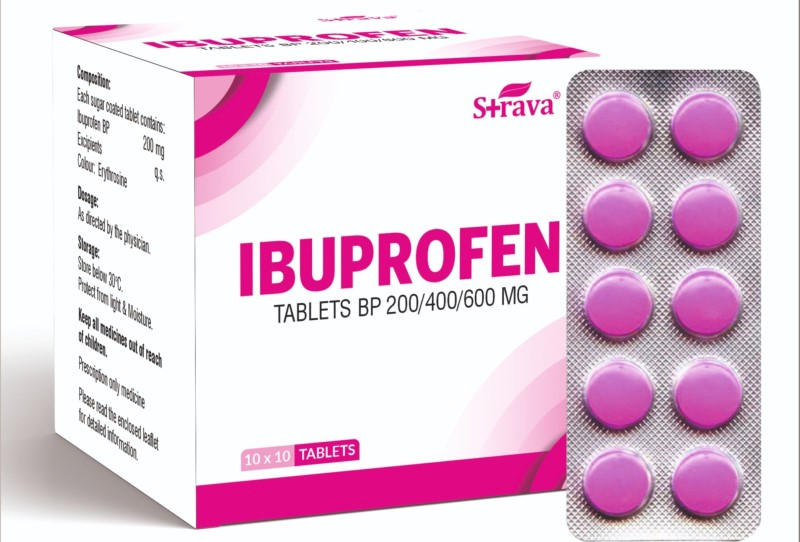

🔹 **Tên:** Dorzolamidum
💊 **Mô tả:** "B?nh glaucoma (t?ng nh?n  p) ?? gi?m  p l?c trong m?t"
🔗 **Mã DrugBank:** DB005
🖼️  Ảnh thuốc: /content/drive/MyDrive/AI_Project/dataset/drug_images/dorzolamidum.jpg


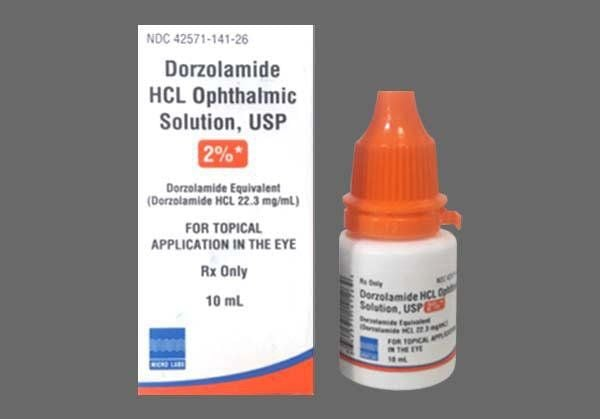

🚀 Đang xử lý ảnh đơn thuốc: 38.jpg
📄 Kết quả OCR:
NETAJI SUBHAS CHANDRA BOSE CANCER HOSPITAL (A Unit of Himadri Memotial Cancer Welfare Trust) NCRI Flaccatonto J08 | Nayabad,Kolkata 700 024 , India Desk (033) 7122J000 Mob 98742[0603 9874210067 Email inloonsch in , admintoinacti in, Wcb Wv ncIllin Doctor Prescription Paticnt Shila Dasgupta Doctor Name Dr,Soumcn Das MRNo a (Surgical Oncolosy Departinem) NCkI/34795 Appointmcnt 16-(14-2022 Sct Age 57 HeightAcight BP' / Fulse / (agen 1| svnptoms Clinical Examination Ilk luf WJM 2xu (e Ros Dragnosis T5Nj lr' 6 UCG : Ro BARAD 4 Uso Investigation Suggested PNAC Owikave LkCg Medicine Prescribed @mbrdus Cove Ps ' bxew 2 , PET CT Jcan TDY 60HA4 3 , Ruv Nert Follow up Date IX FBS Dr: Sounen D)a; No: 62701 MS FACS USAAMRCS(Edin) FRC S(Glasg} Chiel Consul 4nt Hresu Bowel MPFC Senis CANCER CARE AT AFFORDABLE COST Help Name Dale Mnstory kisr_ Cxeut buclA Duply Regn
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 

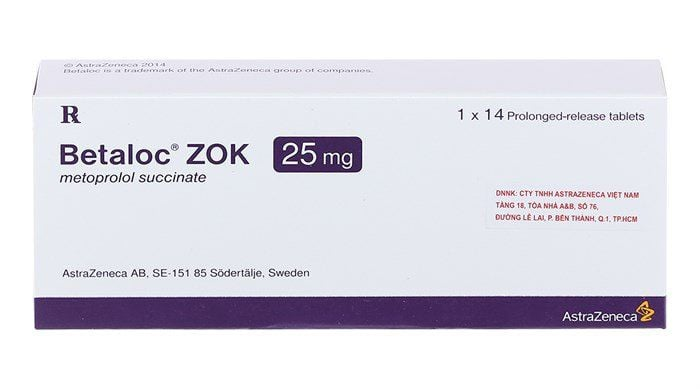

🚀 Đang xử lý ảnh đơn thuốc: 40.jpg
📄 Kết quả OCR:
Ugiiaki Kishan iukugu MD DNE (Int; 'Aedicing €MC Vellore} YASHODA Consultant Physicen & Dibebolorix HOSPITALS No; 79602 Mobile; 770293264 Email drharikishangmall cot 3 | 8124 RAama clawdn (lo 60 L Cuiculy Ly (ay" Au( htoZceicn) A€ ( ( Cofom Anq(fom € S 0 {A6 } 3ou ~( (u ( & G40 ooJ (X7joy Dr: HARI KISHAN BOORUGU CONSULTANT PHYSICIRADNB Regd No; 79692 MASHODA HOSPITALS Somajiguda, Hyderabad-500 082 TALS; SOMAJIGUDA For EMERGENCYIQUERIES FOR APPOINTMENTS Sorajiguda; Hyderabad; Telangana 500 082 040 6723 2321(24 HRS) 040 4567 4567 (24 HrS athodamalcom wyashodahospilals com Rege Ostofo"
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 37.jpg
📄 Kết quả OCR:
Columbie 36 DR. W. P BAKER Physician and Surreon Office and Raidence, Kcefe Building Hilknan City . Scattle R rh O Daen For ~lit @ano&i 6~s. 227 Cozo @hevwo! 20 X V ! Fn e/& ~o&61 Xu 2 Lp M D COLUMBIA TAKE THIS TO CAMERONS DRUG STORE HILLMAN Columbia 

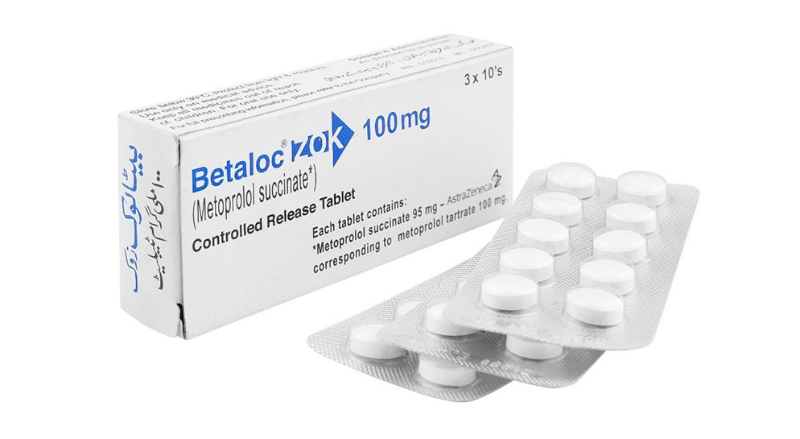

🚀 Đang xử lý ảnh đơn thuốc: 76.jpg
📄 Kết quả OCR:
MletLxo_ 1om M luul
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 83.jpg
📄 Kết quả OCR:
Date: Li4o_2Oto Aptus Medical Arts WE Hansen 123 Homestead PL Suite 2 1 Searchlight; NV 89046 Name: Iyeeteive (MJF Age: 51 Address: MilnLmi_RL Wt: L R Losnian 50 Ta6s , Dispense #30 Sig: T(ke on6 4 daily in The | koe Wood ueessevee conzeo€ Refill (ix times Signature 'WE_Hansen_Ip Generic Substitution 0K DEA #: I~ 46kg milliglam motih 'momnin
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn thuốc: 88.jpg
📄 Kết quả OCR:
RADIO LSEA Confirming USA our QSO of:_ 13 20_ AT 214 UTC Mode 334 0 ON_ I i> MHz RST_ S HAM ALOHAe AxCvR OTHER 722 www.arrlorg OUTPUT 1zZ WATTS ANT 1 To: LA UP MtRS: CIS4 VE/5164 REMARKS: 710 a_ ^ Zu_ LsLUze 31L~ 2 2 22331 4s RS Fzc nz_ Zan 71z _ CL Tr 0 L4eh_z-7225 73w ] 73 [zu QSed p/sh12 ZP3FFos2 TNX TTTTTTTAA,LLAAml,uH Akhlh 217 Cug Ily
🔍 Tên thuốc nhận diện: []

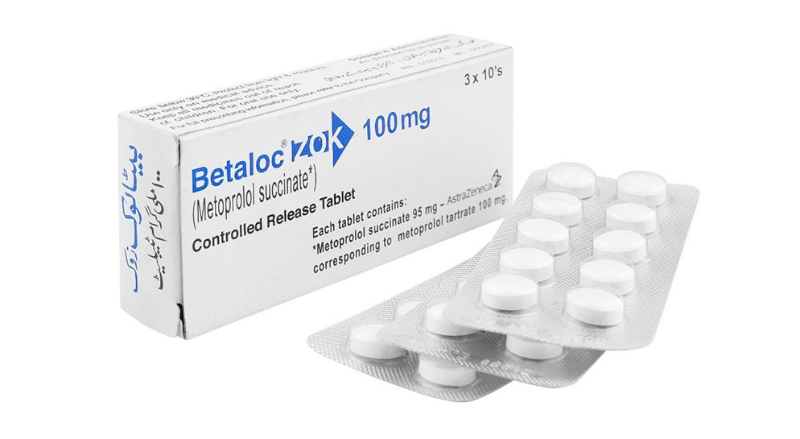

🔹 **Tên:** Dorzolamidum
💊 **Mô tả:** "B?nh glaucoma (t?ng nh?n  p) ?? gi?m  p l?c trong m?t"
🔗 **Mã DrugBank:** DB005
🖼️  Ảnh thuốc: /content/drive/MyDrive/AI_Project/dataset/drug_images/dorzolamidum.jpg


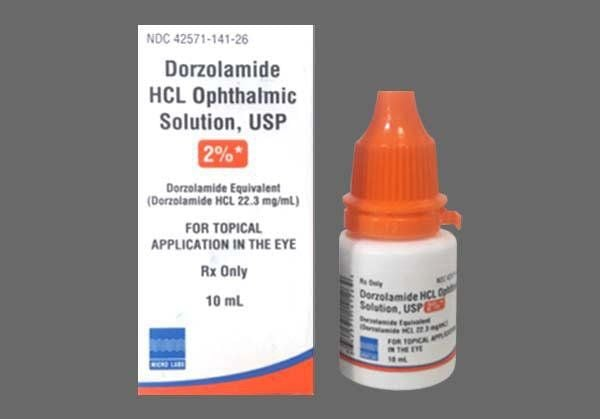

🚀 Đang xử lý ảnh đơn thuốc: 98.jpg
📄 Kết quả OCR:
D4 - (efu (zo1( RAMAIAH PATIENT DATE Memorial Hospltal PRESCRIPTION suf4edzu CgW4-262 Namre Shaileka_kamal Hosp. No: PKQQ22)LOl_ Age Sex R Inj PeMbESIVir 6u filowed bx (et 4 (Day 2 ~Jays) Guu (3310 9 reactions contact your doctor immediately Ph : 2360 e888 Note: In case of any adverse Mh0ob 560 054 Vunkramalat-Indt org Msram h eon Msrt2960 808310088 F080 22183270 Suatnaniacem (0080 2880 314- Dy Looms Aayy iN (oOmg
🔍 Tên thuốc nhận diện: ['RAM']
✅ **Thông tin thuốc được trích xuất:**
🔹 **Tên:** nan
💊 **Mô tả:** nan
🔗 **Mã DrugBank:** DB008
🚀 Đang xử lý ảnh đơn thuốc: 97.jpg
📄 Kết quả OCR:
RIVERSIDE MEDICAL CENTRE 824 [4" Street New York; NY 91743. USA NAME JeLa Sotl AGE 34 ADDRESS 162 St_ML DATE 02-1IZ Betaloc IOO~a +45 Bid Dorzolamizvm I0 ~3 +45 BD Cimetigine 50 ~3 2 +45, TiD Oxprelol +45 Dc.Steve_JoLason signature DLABEL REFILL 0(D2 3 4 5 PRN Exanpl 50~3
🔍 Tên thuốc nhận diện: []
❌ Không tìm thấy thuốc nào khớp.
🚀 Đang xử lý ảnh đơn th

In [14]:
from IPython.display import display  # Đảm bảo đã import display từ IPython

# 8. Vòng lặp xử lý hàng loạt ảnh đơn thuốc
# --------------------------------------------------------
for filename in os.listdir(prescription_images_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(prescription_images_folder, filename)
        print(f"🚀 Đang xử lý ảnh đơn thuốc: {filename}")

        # Bước 1: OCR sử dụng hàm ocr_image
        text = ocr_image(image_path)
        print(f"📄 Kết quả OCR:\n{text}")

        # Bước 2: Trích xuất tên thuốc bằng mô hình NER
        extracted_drugs = extract_drug_names(text)
        print(f"🔍 Tên thuốc nhận diện: {extracted_drugs}")

        # Bước 3: Tìm kiếm thông tin thuốc trong DrugBank (Vector Search)
        matched_drugs = []
        for drug in extracted_drugs:
            drug_info = search_drug_info(drug, drugbank_df, index, drug_embeddings)
            if drug_info is not None:
                matched_drugs.append(drug_info)

        # Bước 4: Hiển thị kết quả
        if matched_drugs:
            print("✅ **Thông tin thuốc được trích xuất:**")
            for drug in matched_drugs:
                print(f"🔹 **Tên:** {drug['drug_name']}")
                print(f"💊 **Mô tả:** {drug['description']}")
                print(f"🔗 **Mã DrugBank:** {drug['drug_id']}")

                # Hiển thị ảnh thuốc nếu có cột 'drug_image_path'
                if 'drug_image_path' in drug and pd.notna(drug['drug_image_path']):
                    # Loại bỏ ký tự "/" thừa ở đầu nếu có
                    drug_img_relative = drug['drug_image_path'].lstrip("/")
                    drug_img_path = os.path.join(drug_images_folder, drug_img_relative)
                    if os.path.exists(drug_img_path):
                        try:
                            # Mở ảnh bằng Pillow (PIL)
                            drug_img = Image.open(drug_img_path)
                            print(f"🖼️  Ảnh thuốc: {drug_img_path}")
                            display(drug_img)
                        except Exception as e:
                            print(f"🚨 Lỗi khi mở ảnh: {e}")
                    else:
                        print(f"🚨 Không tìm thấy ảnh cho thuốc: {drug['drug_name']}")
        else:
            print("❌ Không tìm thấy thuốc nào khớp.")

print("Hoàn tất xử lý tất cả ảnh đơn thuốc!")


# Mục mới